# Tutorial

In [1]:
import os
import sys
import pandas as pd
import json
import matplotlib.pyplot as plt
import networkx as nx
import fornax

%matplotlib inline
from IPython.core.display import SVG

# Add project root dir
ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)

To install the use the dependencies for this notebook:

```bash
conda env create -f environment.yml
source activate fornax_tutorial
```

To run this notebook from the project root:

```bash
cd docs/tutorial
jupyter-notebook
```

In this tutorial we will:

* Load a graph of superheros and their teams from csv files

* Search for nodes in the graph using a string similarity function

* Use fornax to search for nodes using string similarity and fuzzy graph matching

The data in this tutorial we be generated using the preceding notebook: `Tutorial1.ipynb`.

## Introduction

`nodes.csv` and `edges.csv` contain a graph of superheros and their teams along with alternative names for those heros and groups (or aliases).

The image below uses the example of Iron Man, who is known as "Tony" to his friends.
Iron man is a member of the Avengers, a.k.a. Earth's Mightiest Superheros.
Other heros are also members of The Avengers, and they will also have aliases.
Other heros will also be members of other teams and so and so forth.


All of these heros, teams and aliases together make our target graph, a graph which we will search using fornax.

In [2]:
SVG('../img/iron_man.svg')

Let's load the data into the notebook using pandas.

In [3]:
# used for converting csv values in nodes.csv
mapping = {
    '0': 'hero',
    '1': 'team', 
    '2': 'hero_alias', 
    '3': 'team_alias'
}

nodes_df = pd.read_csv(
    './nodes.csv', 
    # rename the columns as targets as this will form the target graph
    # (the graph which we will be searching)
    names=['target_label', 'target_type', 'target_id'],
    # ignore the header
    header=0,
    converters = {
        # convert target_type from numeric values to
        # literal string representations for ease of reading
        'target_type': lambda key: mapping.get(key)
    }
)

# contains pairs of target node ids
edges_df = pd.read_csv('./edges.csv')

We can see that the target nodes have a label (the hero's primary name).
The target_type column will be one of `hero`, `team`, `hero alias`, `team alias`, the four types of nodes in the graph.

(Note that by hero we mean a person in a comic book who has superpowers regardless of them being good or bad)

In [4]:
nodes_df['target_label'].head()

0          Colossus
1    Rachel Summers
2       Black Widow
3          Bullseye
4            Medusa
Name: target_label, dtype: object

Edges are pairs of `target_id` values.
Note that fornax deals with undirected graphs so there is no need to add the edge in the reverse direction.
Doing so will cause an exception as the edge will be considered a duplicate.

In [5]:
edges_df.head()

,end,start
0,1367698142,2105314676
1,1367698142,298635603
2,960914772,1897346471
3,960914772,2027281781
4,849109791,347320780


## Label similarity

For some motivation, before using fornax, let us search for nodes just using their labels.
Let's search for nodes similar to `guardians`, `star` and `groot`.

We will create a function that given a pair of labels, it will return a score where:

$$0 <= score <= 1$$

Secondly we'll create a search function that returns rows from our table of target nodes that have a non zero similarity score.

In [6]:
def node_scoring_function(first: str, second: str):
    """ node scoring function takes two strings and returns a 
        score in the range 0 <= score <= 1
    """
    first_, second_ = sorted((first.lower(), second.lower()), key=len)
    # if first is not a substring of second: score = 0
    if not first_ in second_:
        return 0
    # otherwise use the relative difference between
    # the two lengths
    score = len(second_) - len(first_)
    score /= max(len(first_), len(second_))
    score = 1. - score
    return score

In [7]:
def search(query_id: int, query_label: str):
    # compute all of the scores
    scores = nodes_df['target_label'].apply(
        node_scoring_function, 
        args=(query_label,)
    )
    # create a boolean mask
    mask = scores > 0
    # graph the non zero scoring nodes
    matches = nodes_df[mask].copy()
    # add extra columns
    matches['score'] = scores[mask]
    matches['query_label'] = query_label
    matches['query_id'] = query_id
    return matches

### Aside:
Note that these string search functions are not terribly efficient.
They involve repeated full scans of the target nodes table.
If we were searching a larger graph we could use a search tree as an index, an external sting matching service or database. However, since this is a tutorial, the above functions are simpler and more reproducible.
This is important as we will be using these search results with fornax.

In [8]:
query_labels = ['guardians', 'star', 'groot']

Examining the table below we can see that we have a conundrum.
There are 22 nodes with varying similarity to `star` and 4 nodes similar to `galaxy`.

In [9]:
# find the nodes similar to 'guardians', 'star' and 'groot'
matches = pd.concat(search(id_, label) for id_, label in enumerate(query_labels))
matches

,target_label,target_type,target_id,score,query_label,query_id
262,Guardian,hero,1081675,0.888889,guardians,0
405,Guardians of the Galaxy,team,870807271,0.391304,guardians,0
483,Guardians of the Galaxy (1969 team),team,1295400389,0.257143,guardians,0
994,Guardian,hero_alias,2062791326,0.888889,guardians,0
10,Firestar,hero,274821742,0.500000,star,1
15,Danielle Moonstar,hero,2083850919,0.235294,star,1
69,Star-Lord,hero,1061867605,0.444444,star,1
87,Northstar,hero,1260880284,0.444444,star,1
174,Darkstar,hero,1276753309,0.500000,star,1
269,Starfox,hero,1594294259,0.571429,star,1


Fornax enables a more powerful type of search. 
By specifying 'guardians', 'star', 'groot' as nodes in a graph, 
and by specifying the relationships between them, 
we can search for nodes in our target graph with the same relationships.

## Creating a target graph

Fornax behaves much like a database. In fact it uses SQLite or Postgresql to store graph data and index it.
To insert a new graph into fornax we can use the following three steps:
1. create a new graph
2. add nodes and node meta data
3. add edges and edge meta data

The object `fornax.GraphHandle` is much like a file handle. It does not represent the graph but it is an accessor to it.
If the `GraphHandle` goes out of scope the graph will still persist until it is explicitly deleted, much like a file.

In [10]:
conn = fornax.Connection()
conn.open()

In [11]:
target_graph = fornax.GraphHandle.create(conn)
target_graph.add_nodes(
    # use id_src to set a custom id on each node 
    id_src=nodes_df['target_id'],
    # use other keyword arguments to attach arbitrary metadata to each node
    label=nodes_df['target_label'],
    # the type keyword is reserved to we use target_type
    target_type=nodes_df['target_type']
    # meta data must be json serialisable
)
target_graph.add_edges(edges_df['start'], edges_df['end'])

We can use the `graph_id` to access our graph in the future.

In [12]:
target_graph.graph_id
another_target_graph_handle = fornax.GraphHandle.read(conn, target_graph.graph_id)
another_target_graph_handle == target_graph

True

## Creating a query graph

Let's imagine that we suspect `groot` is directly related to `guardians` and `star` is also directly related to `guardians`.
For example `groot` and `star` could both be members of a team called `guardians`.
Let's create another small graph that represents this situation:

In [13]:
# create a new graph
query_graph = fornax.GraphHandle.create(conn)

# insert the three nodes: 
#   'guardians' (id=0), 'star' (id=1), 'groot' (id=2)
query_graph.add_nodes(label=query_labels)

# alternatively:
#    query_graph.add_nodes(id_src=query_labels)
# since id_src can use any unique hashable items

edges = [
    (0, 1), # edge between groot and guardians
    (0, 2)  # edge between star and guardians
]

sources, targets = zip(*edges)
query_graph.add_edges(sources, targets)

## Search

We can create a query in an analogous way to creating graphs using a `QueryHandle`,
a handle to a query stored in the fornax database.
To create a useful query we need to insert the string similarity scores we computed in part 1.
Fornax will use these scores and the graph edges to execute the query.

In [14]:
query = fornax.QueryHandle.create(conn, query_graph, target_graph)
query.add_matches(matches['query_id'], matches['target_id'], matches['score'])

Finally we can execute the query using a variety of options.
We specify we want the top 5 best matches between the query graph and the target graph.

In [15]:
%time results = query.execute(n=5)

CPU times: user 79.2 ms, sys: 4.3 ms, total: 83.5 ms
Wall time: 80.8 ms


/Users/dstaff/anaconda3/envs/fornax/lib/python3.6/site-packages/numpy/core/records.py:513: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.15 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))


## Visualise

`query.execute` returns an object describing the search result.
Of primary interest is the `graph` field which contains a list of graphs in `node_link_graph` format.
We can use networkx to draw these graphs and visualise the results.

In [16]:
def draw(graph):
    """ function for drawing a graph using matplotlib and networkx"""
    
    # each graph is already in node_link_graph format 
    G = nx.json_graph.node_link_graph(graph)
    
    labels = {node['id']: node['label'] for node in graph['nodes']}
    node_colour = ['r' if node['type'] == 'query' else 'b' for node in graph['nodes']]
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=600, node_color=node_colour, alpha=.3)
    edgelist = [(e['source'], e['target']) for e in graph['links'] if e['type'] != 'match']
    nx.draw_networkx_edges(G, pos, width=3, edgelist=edgelist, edge_color='grey', alpha=.3)
    edgelist = [(e['source'], e['target']) for e in graph['links'] if e['type'] == 'match']
    nx.draw_networkx_edges(G, pos, width=3, edgelist=edgelist, style='dashed', edge_color='pink')
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif', labels=labels)

Result 1 contains the best match. The three query nodes (in red) best match the three target nodes (in blue). The dashed lines show which pairs of query and target nodes matched each other. The blue nodes are a subgraph of the target graph. Note that the result does not describe the whole target graph because in principle it can be very large.

Here we can see that the blue subgraph has exactly the same shape as the red query graph. However, the labels are not exactly the same (e.g. `guardians != Guardians of the Galaxy`) so the result scores less than the maximum score of 1.
However, we can see that our query graph is really similar to Groot and Star-Lord from Guardians of the Galaxy.
Since this is the best match we know that 

/Users/dstaff/anaconda3/envs/fornax/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


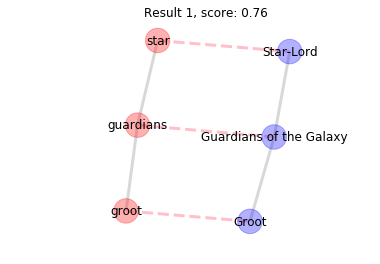

In [17]:
for i, graph in enumerate(results['graphs'][:1]):
    plt.title('Result {0}, score: {1:.2f}'.format(1, 1. - graph['cost']))
    draw(graph)
    plt.xlim(-1.2,1.2)
    plt.ylim(-1.2,1.2)
    plt.axis('off')
    plt.show()

Results 2-4 have a lower score because `star` matches to a different node not adjacent to Guardians of the Galaxy. Further inspection would show that `star` has matched aliases of Star-Lord which are near Guardians of the Galaxy but not ajacent to it.

/Users/dstaff/anaconda3/envs/fornax/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


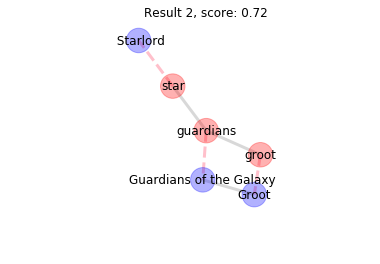

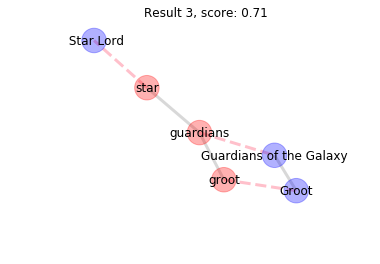

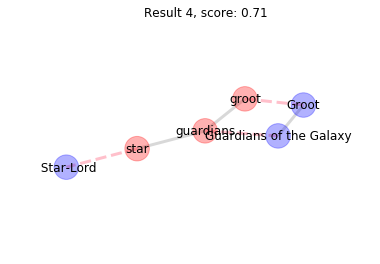

In [18]:
for i, graph in enumerate(results['graphs'][1:4]):
    plt.title('Result {0}, score: {1:.2f}'.format(i+2, 1. - graph['cost']))
    draw(graph)
    plt.xlim(-1.2,1.2)
    plt.ylim(-1.2,1.2)
    plt.axis('off')
    plt.show()

The final match pairs `guardians` and `star` to two nodes that do not have similar edges to the target graph. `groot` is not found in the target graph. The result gets a much lower score than the preceding results and we can be sure that any additional results will also be poor because the result are ordered.

/Users/dstaff/anaconda3/envs/fornax/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


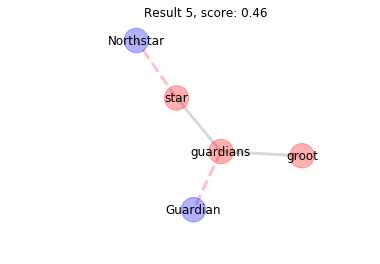

In [19]:
for i, graph in enumerate(results['graphs'][4:]):
    plt.title('Result {0}, score: {1:.2f}'.format(i+5, 1. - graph['cost']))
    draw(graph)
    plt.xlim(-1.2,1.2)
    plt.ylim(-1.2,1.2)
    plt.axis('off')
    plt.show()